In [1]:
from scipy.signal import firwin, lfilter, kaiserord, argrelmin
from scipy.interpolate import interp1d, CubicSpline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib as mpt
import numpy as np
import math

# WALK ON: GAIT RECOGNITION IN-THE-WILD

## Introduction

The widespreading of wearable and portable IoT devices is greatly improving quality of life thanks to the development of 5G and data analysis techniques. Every device we use can collect data regarding our daily activities and use it to help improve their practice. However this can also lead to great security and privacy vulnerabilities when the data handling procedure is not carried out correctly.

With the data collected from devices we already carry every day (like our smartphones), it is possible to collect gait data that can be used to identify activities or individuals.

## Objective

This project has the objetive to use gait data collected from different subject's phones to create and train a deep learning model that will be capable of identifying users given their gait information.

In particular data from the accelerometer and gyroscope will be used to detect signal sequences relative to a step. These will then be classified to identify different users depending on their walking patterns.

This problem can be divided in two smaller tasks i.e. extraction of the signal relative to a step (this can be done with standard signal processing techniques), and then classification using a neural network.

The former will be addressed with the procedure proposed in [1], which was developed for mobile phone sensors, but can easily be extended to any other wearable device. Classification, on the other hand, will be addressed with a simple CNN.

[1] Gadaleta, Matteo, and Michele Rossi. "Idnet: Smartphone-based gait recognition with convolutional neural networks." Pattern Recognition 74 (2018): 25-37.

## Dataset acquisition

In [1]:
!mkdir datasets

The datasets used for the exploration and development of this project are given by [2]. There are four datasets dedicated to the goals this project wants to achieve, so every one of them will be used in order to more accurately measure the results obtained by the developed model.

To test the model with all the different datasets, the reading of the desired dataset should be done first and then all the remaining processes should be runned afterwards. Everytime it is intended to switch the analyzed dataset, the process should be repeated.

[2] Zou Q, Wang Y, Zhao Y, Wang Q and Li Q, Deep learning-based gait recogntion using smartphones in the wild, IEEE Transactions on Information Forensics and Security, vol. 15, no. 1, pp. 3197-3212, 2020.

### Utilities

In this section, a set of utility functions used for the parsing of the devices datasets information is defined.

The focus of the reading of the gait datasets is the conversion of the information into lists of shape Samples * Signals * Axis, where Signals * Axis is a numpy matrix for efficiency purposes.

The focus of the reading of the label datasets is the conversion of the information into lists where each element is a user label for the corresponding sample.

In [3]:
DATASET = 'datasets/dataset'
TRAIN = 'train'
TEST = 'test'
GYROSCOPE = 'gyr'
ACCELEROMETER = 'acc'
EXTENSION = '.txt'

def load_gait_information(x: str, y: str, z: str) -> list:
    '''
    Read all the x, y and z axis signals of a device dataset.

    Args:
        x (str): The path for the dataset of x signals.
        y (str): The path for the dataset of y signals.
        z (str): The path for the dataset of z signals.

    Returns:
        list: The list of loaded samples in the format Samples * Signals * Axis.
    '''

    # Create the final list where the samples will be stored
    axis = []

    # Iterative process for every axis dataset reading
    for path in [x, y, z]:

        # Create a temporary list for storing all the sample signals from the chosen axis
        samples = []

        # Open the dataset file location
        file = open(path, 'r')

        # Read every row of the dataset
        for row in file:

            # Conversion of the signals values and addition to the samples list
            samples.append(np.array(row.strip().split(' '), dtype=np.float32))

        # Addition of the samples list to the axis list
        axis.append(samples)

        # Closing of the read file
        file.close()

    # Convert the samples collected into a matrix
    axis = np.array(axis)

    # Convert the samples matrix to the desired format
    data_matrix = np.transpose(axis, (1, 2, 0))

    # Convert it back into a list where each sample is a signals matrix of type Signals * Axis
    data = [sample for sample in data_matrix]

    # Return the samples list
    return data

def load_dev_gait_information(dataset: int, device: str, purpose: str) -> list:
    '''
    Read all the axis signals for a certain purpose of a certain device.

    Args:
        dataset (int): The number of the intended dataset.
        device (str): The nickname of the device desired.
        purpose (str): The nickname of the purpose desired.

    Returns:
        list: The list of loaded samples in the format Samples * Signals * Axis.
    '''

    # Create the general reading path
    path = f'{DATASET}{dataset}/{purpose}_{device}_'

    # Create the list of reading paths
    paths = []

    # Interate between all the available reading axis
    for axis in ['x', 'y', 'z']:

        # Create the definitive path for each axis
        axis_path = path + axis + EXTENSION

        # Append the created path to the list of paths
        paths.append(axis_path)

    # Read and return the information desired
    return load_gait_information(paths[0], paths[1], paths[2])

def load_output_information(path: str) -> list:
    '''
    Read the subject labels (y) for the gait samples.

    Args:
        path (str): The destination of the labels dataset.

    Returns:
        list: The list of labels for each sample.
    '''

    # Open the label dataset
    file = open(path, 'r')

    # Read and convert every label in the dataset
    labels = [int(label) for label in file]

    # Return the obtained list of labels
    return labels

def load_purpose_output_information(dataset: int, purpose: str) -> list:
    '''
    Read the subject labels for a certain purpose.

    Args:
        dataset (int): The number of the intended dataset.
        purpose (str): The nickname of the purpose desired.

    Returns:
        list: The list of labels for each sample.
    '''

    # Create the path for the dataset
    path = f'{DATASET}{dataset}/y_{purpose}{EXTENSION}'

    # Read and return of the list of labels
    return load_output_information(path)

### Dataset #1 - 118 Subjects, Interpolation

This dataset is collected on 118 subjects and the collected gait data is annotated into steps.

Following the findings that two-step data have a good performance in gait recognition, the gait samples were collected by dividing the gait curve into two continuous steps.

Meanwhile, a single sample is interpolated into a fixed length of 128 (using Linear Interpolation function).

In order to enlarge the scale of the dataset, there is a one-step overlap between two neighboring samples for all subjects. In this way, a total number of 36,844 gait samples are collected.

The model will use 33,104 samples for training, and the rest 3,740 for test.

In [ ]:
!wget 'https://drive.usercontent.google.com/download?id=1yPNWWeubU9SjRKqW7H4-q0BaNsw57jWc&export=download&authuser=0&confirm=t&uuid=f7baf6b2-4139-40d1-b1c1-9ff21f5d696d&at=AIrpjvMKaZOBaOKN_juwrHVVepG3%3A1737392898709' -O datasets/dataset1.zip

!unzip datasets/dataset1.zip -d datasets/dataset1

!find datasets/dataset1 -mindepth 2 -type f -exec mv -t datasets/dataset1 {} +

!rm -r datasets/dataset1/Dataset\ \#1

!rm datasets/dataset1.zip

Archive:  datasets/dataset1.zip
   creating: datasets/dataset1/Dataset #1/
   creating: datasets/dataset1/Dataset #1/test/
   creating: datasets/dataset1/Dataset #1/test/Inertial Signals/
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_acc_x.txt  
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_acc_y.txt  
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_acc_z.txt  
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_gyr_x.txt  
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_gyr_y.txt  
  inflating: datasets/dataset1/Dataset #1/test/Inertial Signals/test_gyr_z.txt  
  inflating: datasets/dataset1/Dataset #1/test/y_test.txt  
   creating: datasets/dataset1/Dataset #1/train/
   creating: datasets/dataset1/Dataset #1/train/Inertial Signals/
  inflating: datasets/dataset1/Dataset #1/train/Inertial Signals/train_acc_x.txt  
  inflating: datasets/dataset1/Dataset #1/train/Inertial Signals/tra

In [9]:
# Train Data
accelerometer_train = load_dev_gait_information(1, ACCELEROMETER, TRAIN)
gyroscope_train = load_dev_gait_information(1, GYROSCOPE, TRAIN)
output_train = load_purpose_output_information(1, TRAIN)

# Test Data
accelerometer_test = load_dev_gait_information(1, ACCELEROMETER, TEST)
gyroscope_test = load_dev_gait_information(1, GYROSCOPE, TEST)
output_test = load_purpose_output_information(1, TEST)

# Store the first sample from accelerometer train dataset
acc_step_template = accelerometer_train[0]

### Dataset #2 - 20 Subjects, Interpolation

This dataset is collected on 20 subjects and the collected gait data is annotated into steps.

Following the findings that two-step data have a good performance in gait recognition, the gait samples were collected by dividing the gait curve into two continuous steps.

Meanwhile, a single sample is interpolated into a fixed length of 128 (using Linear Interpolation function).

As each subject in this dataset has a much larger amount of data as compared to the that in the previous dataset, there is no need to make overlap between the samples.

Finally, a total number of 49,275 samples are collected, in which 44,339 samples are used for training, and the rest 4,936 for test.

In [22]:
!wget 'https://drive.usercontent.google.com/download?id=1ET_YY8CYQTKQb1mvSd4EAQuv4OymEBAZ&export=download&authuser=0&confirm=t&uuid=04c82399-f8b8-454b-8654-b1ce8116a87a&at=AIrpjvPyNZnVBR50jsGa6xEFFbFg%3A1737750965202' -O datasets/dataset2.zip

!unzip datasets/dataset2.zip -d datasets/dataset2

!find datasets/dataset2 -mindepth 2 -type f -exec mv -t datasets/dataset2 {} +

!rm -r datasets/dataset2/Dataset\ \#2

!rm datasets/dataset2.zip

--2025-02-10 13:04:36--  https://drive.usercontent.google.com/download?id=1ET_YY8CYQTKQb1mvSd4EAQuv4OymEBAZ&export=download&authuser=0&confirm=t&uuid=04c82399-f8b8-454b-8654-b1ce8116a87a&at=AIrpjvPyNZnVBR50jsGa6xEFFbFg%3A1737750965202
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.209.1, 2a00:1450:4002:411::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.209.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159996064 (153M) [application/octet-stream]
Saving to: ‘datasets/dataset2.zip’

datasets/dataset2.z 100%[===================>] 152,58M  8,25MB/s    in 21s     

2025-02-10 13:04:58 (7,34 MB/s) - ‘datasets/dataset2.zip’ saved [159996064/159996064]

Archive:  datasets/dataset2.zip
   creating: datasets/dataset2/Dataset #2/
   creating: datasets/dataset2/Dataset #2/test/
   creating: datasets/dataset2/Dataset #2/test/Inertial Signals/
  inflating: datasets/dataset2/Dataset #2/test/Inertia

In [34]:
# Train Data
accelerometer_train = load_dev_gait_information(2, ACCELEROMETER, TRAIN)
gyroscope_train = load_dev_gait_information(2, GYROSCOPE, TRAIN)
output_train = load_purpose_output_information(2, TRAIN)

# Test Data
accelerometer_test = load_dev_gait_information(2, ACCELEROMETER, TEST)
gyroscope_test = load_dev_gait_information(2, GYROSCOPE, TEST)
output_test = load_purpose_output_information(2, TEST)

### Dataset #3 - 118 Subjects, Time-fixed

This dataset is collected on the same 118 subjects as in the first dataset.

In contrast to the former, the gait curve is divided by using a fixed time length, instead of a step length. Exactly, a sample is collected with a time interval of 2.56 seconds. While the frequency of data collection is 50Hz, the length of each sample is also 128.

Also, an overlap of 1.28 seconds is made to enlarge the dataset.

A total number of 29,274 samples are collected, in which 26,283 samples are used for training, and the rest 2,991 for test.

In [46]:
!wget 'https://drive.usercontent.google.com/download?id=137LunCBjT-dThC9p03eNbySb89D6XbFk&export=download&authuser=0&confirm=t&uuid=ac7b9995-8254-4313-8ab4-2061d2e33e2b&at=AIrpjvMGLkaXj2vYCXhyWXJvBtVH:1737413299469' -O datasets/dataset3.zip

!unzip datasets/dataset3.zip -d datasets/dataset3

!find datasets/dataset3 -mindepth 2 -type f -exec mv -t datasets/dataset3 {} +

!rm -r datasets/dataset3/Dataset\ \#3

!rm datasets/dataset3.zip

--2025-01-20 22:50:04--  https://drive.usercontent.google.com/download?id=137LunCBjT-dThC9p03eNbySb89D6XbFk&export=download&authuser=0&confirm=t&uuid=ac7b9995-8254-4313-8ab4-2061d2e33e2b&at=AIrpjvMGLkaXj2vYCXhyWXJvBtVH:1737413299469
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.180.129, 2a00:1450:4002:403::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.180.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73796294 (70M) [application/octet-stream]
Saving to: ‘datasets/dataset3.zip’

datasets/dataset3.z 100%[===================>]  70,38M  9,56MB/s    in 7,7s    

2025-01-20 22:50:14 (9,14 MB/s) - ‘datasets/dataset3.zip’ saved [73796294/73796294]

Archive:  datasets/dataset3.zip
   creating: datasets/dataset3/Dataset #3/
   creating: datasets/dataset3/Dataset #3/Dataset #3/
   creating: datasets/dataset3/Dataset #3/Dataset #3/test/
   creating: datasets/dataset3/Dataset #3/Dataset #3/tes

In [5]:
# Train Data
accelerometer_train = load_dev_gait_information(3, ACCELEROMETER, TRAIN)
gyroscope_train = load_dev_gait_information(3, GYROSCOPE, TRAIN)
output_train = load_purpose_output_information(3, TRAIN)

# Test Data
accelerometer_test = load_dev_gait_information(3, ACCELEROMETER, TEST)
gyroscope_test = load_dev_gait_information(3, GYROSCOPE, TEST)
output_test = load_purpose_output_information(3, TEST)

### Dataset #4 - 20 Subjects, Time-fixed

This dataset is collected on the same 20 subjects as in the second dataset.

In contrast to the former, the gait curve is divided by using a fixed time length, instead of a step length. Exactly, a sample is collected with a time interval of 2.56 seconds. While the frequency of data collection is 50Hz, the length of each sample is also 128.

No overlap is made between the samples.

Finally, a total number of 39,314 samples are collected, in which 35,373 samples are used for training, and the rest 3,941 for test.

In [ ]:
!wget 'https://drive.usercontent.google.com/download?id=1EA9gIHsGSAnkyjbYin8n9-1YTCzEMbXT&export=download&authuser=0&confirm=t&uuid=77855083-a344-4d10-a79d-3fa88d41a7fd&at=AIrpjvOfNth58sQSfgHkEq3tVHMu%3A1737752465177' -O datasets/dataset4.zip

!unzip datasets/dataset4.zip -d datasets/dataset4

!find datasets/dataset4 -mindepth 2 -type f -exec mv -t datasets/dataset4 {} +

!rm -r datasets/dataset4/Dataset\ \#4

!rm datasets/dataset4.zip

In [ ]:
# Train Data
accelerometer_train = load_dev_gait_information(4, ACCELEROMETER, TRAIN)
gyroscope_train = load_dev_gait_information(4, GYROSCOPE, TRAIN)
output_train = load_purpose_output_information(4, TRAIN)

# Test Data
accelerometer_test = load_dev_gait_information(4, ACCELEROMETER, TEST)
gyroscope_test = load_dev_gait_information(4, GYROSCOPE, TEST)
output_test = load_purpose_output_information(4, TEST)

## Feature Treatment (Steps Extraction)

The steps extraction procedure can be summarized as follows:

* Signal preprocessing: upsampling, to obtain equal sampling frequency for all the considered samples, and filtering to remove high frequency noise.
* Template extraction: the step will be isolated via template matching on the accelerometer magnitude due to its independence from the orientation of the glasses.
* Template matching: given the template use a correlation function and search for the minima to detect the beginning and end of step samples.
* Reference system normalization: since the sensors measurements are relative to their own reference system it is important to transform all the signals into a standard reference system for the whole duration of the step.
* Sample normalization: at this point the extracted data points will not have the same length (since the walking speed can change) so they can't be fed into a convolutional neural network. To solve this the sequences are re-interpolated into fixed length signals.

### No treatment

Before any treatment is made, the data is associated to the variables that will indeed go through the treatment phases.

Besides this usage, this association could also be used if straigh foward network model testing is desired, so the models can be evaluated in performance before any treatment is done.

In [56]:
# Associate the loaded datasets with the final information input

# Train data
final_accelerometer_train = accelerometer_train
final_gyroscope_train = gyroscope_train
final_output_train = output_train

# Test data
final_accelerometer_test = accelerometer_test
final_gyroscope_test = gyroscope_test
final_output_test = output_test

### Data Analysis

Having the dataset information collected and converted, a function was defined to allow the visualization of a graphic structure of the magnitude of the signals of a couple of samples in order to better understand and, therefore, treat the data.

#### Process Definition

In [7]:
# Update the font size of the graphs
mpt.rcParams.update({"font.size":16})

def show_sample(data: list, samples: int = 3) -> None:
    '''
    Show, in a matplot, the graphics of the magnitudes of the signals of a certain number of samples.

    Args:
        data (list): The list of data samples desired.
        samples (int): The number of samples for visualization.
    '''

    # Calculate the number of rows for representation
    rows = math.ceil(samples / 3)

    # Create the plot for graphical showing
    _, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))

    # Iterate over all the rows and collumns
    for row in range(rows):
        for col in range(3):

            # Grab the desired sample
            sample = data[row + col]

            # Grab the axe for printing
            if rows != 1:
                axe = axs[row][col]
            else:
                axe = axs[col]

            # Create its priting plot
            axe.plot(np.linalg.norm(sample, axis=1))
            axe.set_xlabel("Sample number")
            axe.set_ylabel("Sample amplitude")

    # Print the final desired plot in a tight layout
    plt.tight_layout()

#### Data Analysis

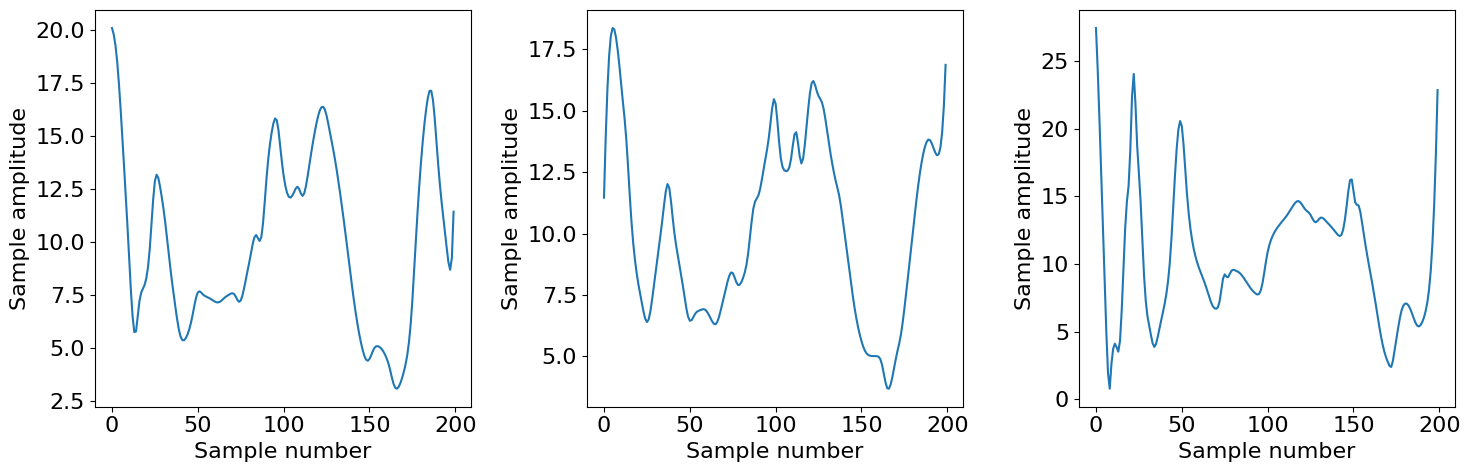

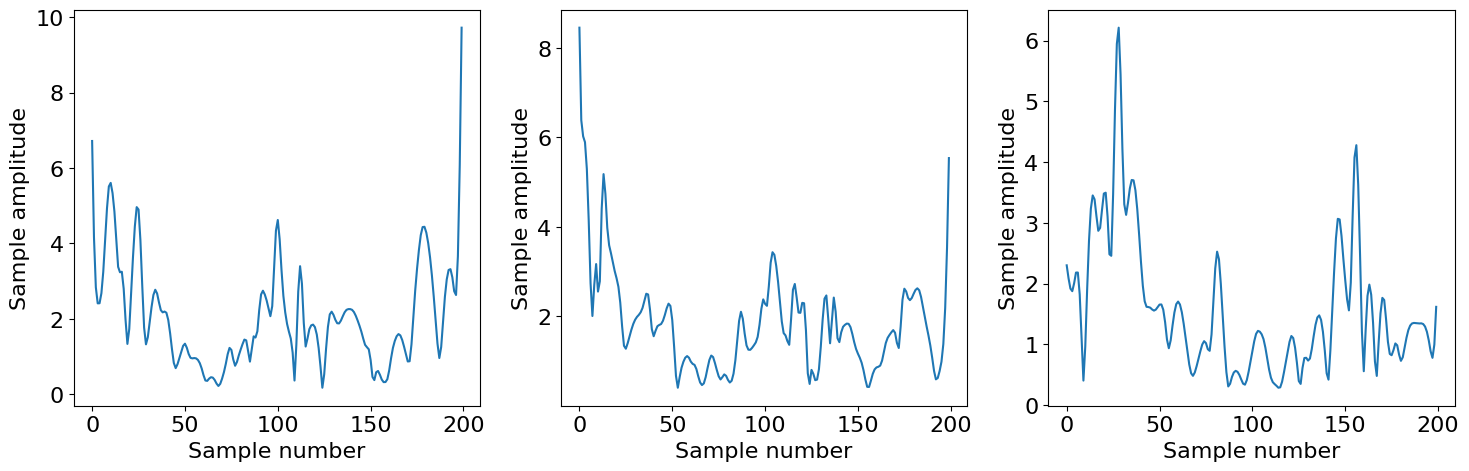

In [72]:
# Print accelerometer samples
show_sample(final_accelerometer_train)

# Print gyroscope samples
show_sample(final_gyroscope_train)

### 0. Signal Concatenation

#### Process Definition

In [10]:
def concatenate_samples(data: list, labels: list) -> tuple[list, list]:
    '''
    Concatenate followed up samples to increase sample size.

    Args:
        data (list): The list of collected samples desired.
        labels (list): The list of labels for the samples.

    Returns:
        tuple[list, list]: The tuple of list of concatenated samples per subject and new labels for those samples.
    '''

    # Create the list to store the new samples
    new_data = []

    # Create the list to store the new labels
    new_labels = []

    # Create a dictionary for faster identification of subjects sample location
    indexes = dict()

    # Iterate over all the labels and their indexes
    for i, label in enumerate(labels):

        # Check if this label has already been added
        if label in indexes.keys():

            # Append the index to the label entry
            indexes[label].append(i)

        else:

            # Create a list on the label entry
            indexes[label] = [i]

    # Iterate over all the labels
    for label in indexes.keys():

        # Append the label to the new label list
        new_labels.append(label)

        # Create the list which will store the new sample
        sample = []

        # Iterate over all the indexes of a label
        for i, index in enumerate(indexes[label]):

            # Check if it is a consecutive sample
            if i % 2 == 0:
                
                # Append the old sample to the new sample
                sample.append(data[index])

        # Convert the sample to be consecutive
        sample = np.array(sample).reshape(-1, 3)

        # Add the consecutive sample to the new data list
        new_data.append(sample)

    # Return the new list of samples and labels
    return new_data, new_labels

#### Application to the data

In [11]:
# Concatenation of train data
final_accelerometer_train, _ = concatenate_samples(final_accelerometer_train, final_output_train)
final_gyroscope_train, final_output_train = concatenate_samples(final_gyroscope_train, final_output_train)

# Concatenation of test data
final_accelerometer_test, _ = concatenate_samples(final_accelerometer_test, final_output_test)
final_gyroscope_test, final_output_test = concatenate_samples(final_gyroscope_test, final_output_test)

### 1. Signal Preprocessing

#### Upsampling

##### Process Definition

In [12]:
def CS_interpolation_sample(sample: np.array, fs_original: int = 50, fs_target: int = 200) -> np.array:
    '''
    Upsample a sample to a higher frequency using cubic spline interpolation.

    Args:
        sample (np.array): The original sample.
        fs_original (int): Original sampling frequency.
        fs_target (int): Target sampling frequency.

    Returns:
        np.array: The upsampled sample.
    '''

    # Calculate the linear space of the original sample
    x = np.linspace(0, (len(sample) - 1) / fs_original, len(sample))

    # Create a cubic spline based on the original sample
    cs = CubicSpline(x, sample)

    # Calculate the linear space of the target sample
    new_x = np.linspace(0, (len(sample) - 1) / fs_original, len(sample) * (fs_target // fs_original))

    # Calculate the interpolated sample
    interplotated_sample = cs(new_x)

    # Return the calculated interpolated sample
    return interplotated_sample

def CS_interpolation_data(data: list, fs_original: int = 50, fs_target: int = 200) -> list:
    '''
    Upsample a list of sample to a higher frequency using cubic spline interpolation.

    Args:
        data (list): The list of samples.
        fs_original (int): Original sampling frequency.
        fs_target (int): Target sampling frequency.

    Returns:
        list: The list of upsampled samples.
    '''

    # Return the list of upsampled samples
    return [CS_interpolation_sample(sample, fs_original, fs_target) for sample in data]

##### Application to the data

In [13]:
# Upsampling of the accelerometer data
final_accelerometer_train = CS_interpolation_data(final_accelerometer_train)
final_accelerometer_test = CS_interpolation_data(final_accelerometer_test)

# Upsampling of the gyroscope data
final_gyroscope_train = CS_interpolation_data(final_gyroscope_train)
final_gyroscope_test = CS_interpolation_data(final_gyroscope_test)

#### Filtering

##### Process Definition

In [603]:
def fir_filter_sample(sample: np.array, frequency: int = 50, cutoff_hz: int = 40, ripple_db: int = 60) -> np.array:
    '''
    Applies a low-pass FIR filter to a sample.
    
    Args:
        sample (np.array): The sample to filter.
        frequency (int): The sampling frequency of the sample.
        cutoff_hz (int): The cutoff frequency in Hz.
        ripple_db (int): The ripple in the passband in decibels.
        
    Returns:
        np.array: The filtered sample.
    '''

    # Calculate the Nyquist rate
    nyquist_rate = 0.5 * frequency

    # Normalize the cutoff frequency by the Nyquist rate
    normalized_cutoff = cutoff_hz / nyquist_rate

    # Calculate the transition width
    width = 5 / nyquist_rate
    
    # Calculate the filter order and beta using the Kaiser window method
    N, beta = kaiserord(ripple_db, width)
    
    # Design the FIR filter using the Kaiser window
    taps = firwin(N, normalized_cutoff, window=("kaiser", beta))

    # Calculate the symmetric padding
    pad = len(taps) // 2
    
    # Apply the FIR filter
    filtered_data = lfilter(taps, 1, sample)
    
    # Return the calculated filtered data with the symmetric padding removed
    return np.array(filtered_data[pad:-pad])

def fir_filter_data(data: list, frequency: int = 50, cutoff_hz: int = 40, ripple_db: int = 60) -> list:
    '''
    Applies a low-pass FIR filter to a list of samples.
    
    Args:
        sample (list): The list of samples to filter.
        frequency (int): The sampling frequency of the sample.
        cutoff_hz (int): The cutoff frequency in Hz.
        ripple_db (int): The ripple in the passband in decibels.
        
    Returns:
        list: The list of filtered samples.
    '''

    # Return the list of filtered samples
    return [fir_filter_sample(sample, frequency, cutoff_hz, ripple_db) for sample in data]

##### Application to the data

In [699]:
SAMPLING_FREQ = 200

# Filtering of the accelerometer data
final_accelerometer_train = fir_filter_data(final_accelerometer_train, SAMPLING_FREQ)
final_accelerometer_test = fir_filter_data(final_accelerometer_test, SAMPLING_FREQ)

# Filtering of the gyroscope data
final_gyroscope_train = fir_filter_data(final_gyroscope_train, SAMPLING_FREQ)
final_gyroscope_test = fir_filter_data(final_gyroscope_test, SAMPLING_FREQ)

### 2. Template Extraction

#### Process Definition

In [14]:
def compute_magnitude_sample(sample: np.array) -> np.array:
    '''
    Compute the magnitude of a sample.

    Args:
        sample (np.array): The sample to calculate the magnitude of.

    Returns:
        np.array: The calculated magnitude of the sample.
    '''

    # Return and calculate the magnitude of the sample
    return np.linalg.norm(sample, axis=1)

def compute_magnitude_data(data: list) -> list:
    '''
    Compute the magnitude of the samples of a list of samples.

    Args:
        data (list): The list of samples.

    Returns:
        list: The list of samples in magnitudes.
    '''

    # Return and calculate the magnitude of the given sample list
    return [compute_magnitude_sample(sample) for sample in data]

def corr_distance(u: np.array, v: np.array) -> float:
    '''
    Calculate the correlation between two given samples.

    Args:
        u (np.array): The first sample to calculate the correlation with.
        v (np.array): The second sample to calculate the correlation with.

    Returns:
        float: The calculated correlation of the given samples.
    '''

    # Calculate the mean for the first sample
    u_hat = np.mean(u)

    # Calculate the mean for the second sample
    v_hat = np.mean(v)

    # Normalize both samples with their means
    u = u - u_hat
    v = v - v_hat

    # Calculate the correlation between the two samples
    corr = 1 - np.dot(u, v) / np.linalg.norm(u) * np.linalg.norm(v)

    # Return the calculated correlation
    return corr

In [21]:
def compute_magnitude(data: list) -> list:
    '''
    Compute the magnitude of the samples of a list of samples.

    Args:
        data (list): The list of samples.

    Returns:
        list: The list of samples in magnitudes.
    '''

    # Return and calculate the magnitude of the given sample list
    return [np.linalg.norm(sample, axis=1) for sample in data]

# correlation distance computation
def corr_distance(u: np.array, v: np.array) -> float:
    '''
    Calculate the correlation between two given samples.

    Args:
        u (np.array): The first sample to calculate the correlation with.
        v (np.array): The second sample to calculate the correlation with.

    Returns:
        float: The calculated correlation of the given samples.
    '''

    # Calculate the mean for the first sample
    u_hat = np.mean(u)

    # Calculate the mean for the second sample
    v_hat = np.mean(v)

    # Normalize both samples with their means
    u = u - u_hat
    v = v - v_hat

    # Calculate the correlation between the two samples
    corr = 1 - np.dot(u, v) / np.linalg.norm(u) * np.linalg.norm(v)

    # Return the calculated correlation
    return corr

def parse_indexes(min_indexes: np.array, corrs: np.array, half_window: int = 20) -> np.array:
    '''
    Check if the minimum indexes given are unique minimas in a given window size.

    Args:
        min_indexes (np.array): An array of found minima indexes.
        corrs (np.array): The array of calculated correlation indexes for the sample where the minimas were found.
        half_window (int): Half the size of the minimum search window.

    Returns:
        np.array: The updated minima array.
    '''

    # checking if there is another minimum in a window of size 2*half_window, if so
    # ignore the current minimum

    # Create the array of parsed indexes
    parsed_indexes = []

    # For every minima index check if there is another minima in the given window
    for index in min_indexes:

        # In case there is another minima, ignore the current one
        if min(half_window, index) == np.argmin(corrs[max(index-half_window, 0):min(index+half_window, len(corrs))]):
            parsed_indexes.append(index)

    # Return the calculated unique minima's array
    return np.array(parsed_indexes)

def compute_template(magnitude_sample: np.array, template_initialization: np.array = None, first_sample_height: float = 12, corr_thr: float = 0.5, window_size: int = 25, frequency: int = 50, ripple_db: int = 60, cutoff_hz: int = 3):
    '''
    Compute the template of a step given a magnitude sample.

    Args:
        magnitude_sample (np.array): The magnitude sample for template computation.
        template_initialization (np.array): The template_initialization for template computation.
        first_sample_height (float): The value for the first peak.
        corr_thr (float): The correlation threshold for template association.
        window_size (int): The size of the search window for template correlation.
        frequency (int): The sampling frequency of the sample.
        cutoff_hz (int): The cutoff frequency in Hz.
        ripple_db (int): The ripple in the passband in decibels.

    Returns:
        np.array: The calculated template for a step.
    '''

    # Calculate the first index where there is a peak
    first_index = np.where(magnitude_sample > first_sample_height)[0][0]

    # Cut everything before the first peak (transitory information)
    processed_sample = magnitude_sample[first_index:].copy()

    # Normalize the signal to improve detection
    processed_sample -= processed_sample.mean()

    # Filter with low cutoff frequency to find where to begin the template
    filtered_sample = fir_filter_sample(processed_sample, frequency, cutoff_hz, ripple_db)

    # Find the second minima of the signal (more stable)
    minima_ind = argrelmin(filtered_sample)[0][1]

    # Search for the actual minima in a one second time window in the original signal
    actual_minima = np.argmin(processed_sample[minima_ind:minima_ind + frequency]) + minima_ind

    # Calculate half of the template size
    half_size = frequency // 2

    # If there is no preinitialized template, select a one second window around the minima
    if template_initialization is None:
        template = processed_sample[actual_minima - half_size:actual_minima + half_size]
    else:
        template = template_initialization.copy()

    # Define the starting window center
    i = half_size

    # Compute the correlation function to detect steps
    while i < len(processed_sample) - window_size - half_size:

        # Create an array to store correlation values
        corrs = []

        # Check all the sub-windows inside the main window
        for j in range(i, i + window_size):

            # Get a sub-window of samples
            sub_sample = processed_sample[j - half_size:j + half_size]

            # Delta function to check if the sample is worth considering
            delta = lambda x: np.max(x) - np.min(x)

            # Check if this is actual walking data or just noise
            if delta(sub_sample) < delta(template) / 10:

                # Set correlation to ignore this sample
                corr = 1

            else:

                # Compute the correlation between the sample and the current template
                corr = corr_distance(template, sub_sample)

            # Add the computed correlation to the list
            corrs.append(corr)

        # Convert array into np.array
        corrs = np.array(corrs)

        # Search for samples whose correlation is smaller than the threshold
        search_indexes = np.where(corrs < corr_thr)[0]

        # Store the correlation values of those samples
        searched_values = corrs[search_indexes]

        # Look for the first minina in the correlation vector
        minima = argrelmin(searched_values)[0]

        # Store the indexes of the minima
        min_indexes = search_indexes[minima]
        
        # Discard minima that are not the absolute minima within a small window (stability)
        min_indexes = parse_indexes(min_indexes, corrs)

        # If no minima found or not enough, break the loop
        if len(min_indexes) < 2:
            break
        
        # Move the window forward based on the detected minima
        i += min_indexes[1]
        
        # Update the template by a weighted average of the old template and the new signal
        template = 0.9 * template + 0.1 * processed_sample[i - half_size:i + half_size]
    
    # Return the obtained template
    return template

#### Application to the data

In [18]:
# Upsample the template sample
upsample_template = normalize_length([acc_step_template], 400)[0]

# Caculate the magnitude of the template sample
magnitude_template = compute_magnitude_sample(acc_step_template)

# Exctract the template from the sample
step_template = magnitude_template[0:200]

### 3. Template Matching

#### Continuous Signal

##### Process Definition

In [57]:
def correct_missing_indexes(min_indexes):
    # getting the median step length
    median = np.median(np.diff(min_indexes))
    start_index = min_indexes[0]
    indexes = [start_index]
    for min_index in min_indexes[1:]:
        # checking if the step interval is greater than 1.5 times the median, if so
        # the interval is divided in round(len(interval) / median intervals)
        if  (min_index - start_index) > 1.5 * median:
            n_missed = int(np.round((min_index - start_index) / median))
            for j in range(1, n_missed):
                indexes.append(
                    int(start_index + j * np.round((min_index - start_index) / n_missed))
                )
        indexes.append(min_index)
        start_index = min_index
    return np.array(indexes)

def count_steps(signal: np.array, template: np.array, thr: float = 0.45) -> list:
    '''
    Calculate the step indexes on a sample, given a step template.

    Args:
        signal (np.array): The sample to extract the steps from.
        template (np.array): The template for a step.
        thr (float): The threshold for the correlation between the sample and the template.

    Returns:
        list: The array of step indexes from the sample.
    '''

    # Calculate the template size
    template_size = len(template)

    # Normalize the signal with the signal mean
    signal -= signal.mean()

    # Create the array to store the correlation of the obtained samples
    corrs = []

    # Iterates over all the possible samples within a signal
    for i in range(len(signal) - template_size):
        
        # Get the sample wanted to test for matching
        sample = signal[i:i+template_size]

        # Delta function to calculate worthness of verification
        delta = lambda x: np.max(x) - np.min(x)

        # Check if the sample is worth checking
        if delta(sample) < delta(template) / 2:

            # Set correlation to ignore this sample
            corr = 1

        else:

            # Calculate the correlation of the sample with the template
            corr = corr_distance(template, sample)

        # Append the calculate correlation
        corrs.append(corr)

    # Convert correlation array into np.array
    corrs = np.array(corrs)

    # Same as above, finding the indexes of the minima and removing bad ones
    search_indexes = np.where(corrs < thr)
    searched_values = corrs[search_indexes]
    minima = argrelmin(searched_values)[0]
    search_indexes = search_indexes[0]
    min_indexes = search_indexes[minima]
    min_indexes = parse_indexes(min_indexes, corrs)

    # this function should be used only if you are sure that a person kept walking,
    # in this way you can make sure that even if a step is not detected a good
    # estimate of the step is still obtained
    new_indexes = sorted(correct_missing_indexes(min_indexes))

    # Return the list of calculated step indexes
    return new_indexes

def count_steps_all(magnitude_data: np.array, template: np.array, thr: float = 0.45) -> list:
    '''
    Calculate the step indexes on all the samples collected by the accelerometer, given a step template.

    Args:
        magnitude_data (np.array): The array of the magnitude of all samples collected by the accelerometer.
        template (np.array): The template used for step matching.
        thr (float): The correlation threshold for template matching.

    Returns:
        list: An array of the cycles of all the samples collected.
    '''

    # Build and return the array of cycle indexes of all samples
    return [count_steps(signal, template, thr) for signal in magnitude_data]

def get_cycles(cycles: list, data: np.array) -> list:
    '''
    Transform the samples to have only steps in them.

    Args:
        cycles (list): The array of step cycles.
        data (np.array): The array of data sampled from a device.

    Returns:
        list: The array of the resampled data.
    '''

    # Create an array which is gonna store the new data
    new_data = []

    # Iterate over all the samples contained in the data
    for sample_i in range(len(data)):

        # Create the array which is gonna store the new signal
        pieces = []

        # Define the sample for this iteration
        signal = data[sample_i]
        cycle = cycles[sample_i]

        # Iterate over all the steps
        for step_i in range(len(cycle) - 1):

            # Add the step exctracted from the sample to the final sample
            pieces.append(signal[cycle[step_i]:cycle[step_i+1]].reshape((cycle[step_i+1] - cycle[step_i], -1)))

        # Append the steps collected to the new data
        new_data.append(pieces)

    # Convert and return the new data into np.array
    return new_data

##### Application to the data

In [64]:
print(len(final_accelerometer_train[0]))

86528


In [59]:
magnitude = compute_magnitude_data(final_accelerometer_train)
magnitude_test = compute_magnitude_data(final_accelerometer_test)

# Calculate the step cycles of every sample
cycles = count_steps_all(magnitude, step_template)
cycles_test = count_steps_all(magnitude_test, step_template)

# Resample the accelerometer data for including only steps
steps_accelerometer_train = get_cycles(cycles, final_accelerometer_train)
steps_accelerometer_test = get_cycles(cycles_test, final_accelerometer_test)

# Resample the gyroscope data for including only steps
steps_gyroscope_train = get_cycles(cycles, final_gyroscope_train)
steps_gyroscope_test = get_cycles(cycles_test, final_gyroscope_test)

/home/guinucool/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guinucool/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0

#### Interpolated Step-Length Annotated Sample

As refered earlier, two of the considered datasets for the user classification task present data samples already annotated and interpolated into a two step length.

This means that each sample collected on those datasets represents exactly two steps taken by the user the sample wants to identify, which can simply be exctracted by dividing the sample in half.

##### Process Definition

In [53]:
def step_extraction_sample(sample: np.array, step_length: int = 64) -> list:
    '''
    Exctract the steps from a interpolated step annotated sample.

    Args:
        sample (np.array): The sample which is wanted for the step exctraction.
        step_length (int): The step length in the sample.

    Returns:
        list: The sample divided into Steps * Signals * Axis.
    '''

    # Create the list where the steps will be stored
    steps = []

    # Create the start index for the step exctraction
    i = 0

    # While there are steps to extract, exctract them
    while (i + step_length) <= len(sample):

        # Extract a step sample
        steps.append(sample[i:i + step_length].reshape((i + step_length - i, -1)))

        # Increase the start index for the next step
        i += step_length

    # Return the exctracted steps
    return steps

def step_extraction_data(data: list, step_length: int = 64) -> list:
    '''
    Exctract the steps from each of the samples in a device dataset.

    Args:
        data (list): The list of samples collected on the device dataset.
        step_length (int): The step length in the sample.

    Returns:
        list: A list of the device dataset resampled to samples separated into steps of form Samples * Steps * Signals * Axis.
    '''

    # Create and return the new device dataset list
    return [step_extraction_sample(sample, step_length) for sample in data]

##### Application to the data

In [57]:
# Exctract the steps from the accelerometer data
steps_accelerometer_train = step_extraction_data(final_accelerometer_train)
steps_accelerometer_test = step_extraction_data(final_accelerometer_test)

# Exctract the steps from the gyroscope data
steps_gyroscope_train = step_extraction_data(final_gyroscope_train)
steps_gyroscope_test = step_extraction_data(final_gyroscope_test)

### 4. Reference System Normalization

With the steps exctracted from every single sampled, it is now desired that every single one of them follows a common reference system so the signals can be independent from their devices own references systems.

The goal is to achieve in all samples a common reference system that all the signals will be aligned with so it is easier for the model to recognize patterns in samples that might differ in collected enviroment and device but belong to the same subject.

#### Process Definition

In [58]:
def normalize_principal_vector(v: np.array, v0: np.array) -> np.array:
    '''
    Change the direction of vector if it differs a lot in direction with a reference vector.

    Args:
        v (np.array): The vector to check and change direction.
        v0 (np.array): The reference vector.

    Returns:
        np.array: The vector with the required changes.
    '''    

    # Check if the direction of v differs a lot with the direction of v0
    if v.reshape(1, 3)@v0.reshape((3, 1)) < 0:

        # Change direction and return the vector
        return -v
    
    else:

        # Keep and return the vector as original
        return v

def normalize_reference_sample(acc_sample: list, gyr_sample: list) -> tuple[list, list]:
    '''
    Normalize all the steps in a sample to a common reference system.

    Args:
        acc_sample (list): A sample of steps captured by the accelerometer to normalize in the reference system.
        gyr_sample (list): A sample of steps captured by the gyroscope to normalize in the reference system.

    Returns:
        tuple[list, list]: The samples with the steps normalized to the reference system.
    '''

    # Create the lists to store the processed steps
    new_acc_sample = []
    new_gyr_sample = []

    # Iterate over all the steps within a sample
    for i, (acc_step, gyr_step) in enumerate(zip(acc_sample, gyr_sample)):

        # Compute the first axis with the average acceleration
        first_axis = acc_step.mean(axis=0)

        # Compute the normalized gravity vector
        gravity = first_axis.reshape(1, 3) / np.linalg.norm(first_axis)

        # Create the lists that will store the normalized signals of the step
        normalized_acc = []
        normalized_gyr = []

        # Exctract the component along the gravity versor
        normalized_acc.append(acc_step@gravity.T)
        normalized_gyr.append(gyr_step@gravity.T)

        # Remove the component along the gravity axis
        main_direction_acc = normalized_acc[0] * gravity
        main_direction_gyr = normalized_gyr[0] * gravity
        planar_direction_acc = acc_step - main_direction_acc
        planar_direction_gyr = gyr_step - main_direction_gyr

        # Compute PCA along the resulting plane to obtain the remaining directions
        pca_acc = PCA(2).fit(planar_direction_acc)
        pca_gyr = PCA(2).fit(planar_direction_gyr)

        # Exctract the remaing components
        acc_y, acc_z = pca_acc.components_
        gyr_y, gyr_z = pca_gyr.components_

        # Exctract the vectors of the first step to align the other steps components
        if i == 0:
            acc_y0, acc_z0 = acc_y, acc_z
            gyr_y0, gyr_z0 = gyr_y, gyr_z

        # Align the remaining components
        acc_y = normalize_principal_vector(acc_y, acc_y0)
        acc_z = normalize_principal_vector(acc_z, acc_z0)
        gyr_y = normalize_principal_vector(gyr_y, gyr_y0)
        gyr_z = normalize_principal_vector(gyr_z, gyr_z0)

        # Add the remaining components
        normalized_acc.append(acc_step@acc_y.reshape(3, 1))
        normalized_acc.append(acc_step@acc_z.reshape(3, 1))
        normalized_gyr.append(gyr_step@gyr_y.reshape(3, 1))
        normalized_gyr.append(gyr_step@gyr_z.reshape(3, 1))

        # Append the reference system normalized signals to the lists
        new_acc_sample.append(np.concatenate(normalized_acc, axis=1))
        new_gyr_sample.append(np.concatenate(normalized_gyr, axis=1))

    # Return the new normalized samples
    return new_acc_sample, new_gyr_sample

def normalize_reference_data(acc_data_steps: list, gyr_data_steps: list) -> list:
    '''
    Normalize the reference system of all the samples (step exctracted) collected by the accelerometer and gyroscope.

    Args:
        acc_data_steps (list): The list of data samples (step exctracted) collected by the accelerometer.
        gyr_data_steps (list): The list of data samples (step exctracted) collected by the gyroscope.

    Returns:
        list: A list with both devices all reference system normalized samples of shape Samples * Devices * Steps * Signals * Axis.
    '''

    # Create and return the list of the processed samples
    return [normalize_reference_sample(acc_sample, gyr_sample) for acc_sample, gyr_sample in zip(acc_data_steps, gyr_data_steps)]

#### Application to the data

In [59]:
# Normalize the reference system for training data
normalized_reference_samples_train = normalize_reference_data(steps_accelerometer_train, steps_gyroscope_train)

# Normalize the reference system for test data
normalized_reference_samples_test = normalize_reference_data(steps_accelerometer_test, steps_gyroscope_test)

### 5. Sample Normalization

#### Process Definition

In [55]:
def normalize_length(sample: list, target_sample_length: int = 200) -> np.array:
    '''
    Interpolate the steps of a sample into the desired sample length.

    Args:
        sample (list): The list of steps in a sample.
        target_sample_length (int): The desired lenght for the sample.

    Returns:
        np.array: The interpolated sample in the desired Steps * Signals * Axis format.
    '''

    # Create a list to store the normalized steps
    normalized_sample = []

    # Iterate over all the steps for each sample
    for step in sample:

        # Create the vector of signals for this step
        step_vect = []

        # Iterate over all the axis of the step
        for vec in step.T:

            # Get the indexes for all the axis samples
            x = np.arange(len(vec))

            # Create a cubic spline with the characteritcs of the axis signal
            cs = CubicSpline(x, vec)

            # Create the new linear space with the target length
            new_x = np.linspace(0, len(vec), target_sample_length)

            # Calculate the interpolated signal in the desired axis
            interpolated = cs(new_x)

            # Append the interpolated data to the vector
            step_vect.append(interpolated)

        # Append the normalized step to the new sample
        normalized_sample.append(np.vstack(step_vect).T)

    # Convert and return the sample in the desired form
    return np.array(normalized_sample)

def normalize_structure_data_single_step(data: list) -> tuple[np.array, np.array]:
    '''
    Convert and normalize the current compacted data into the desired format (single step) to feed the neural network.

    Args:
        data (list): The list of samples of shape Devices * Steps * Signals * Axis.

    Returns:
        tuple[np.array, np.array]: Tuple of separated device samples with normalized unique step length.
    '''
    
    # Create the final list of accelerometer normalized samples
    normal_acc = []

    # Create the final list of gyroscope normalized samples
    normal_gyr = []
    
    # Iterate over all the accelerometer and gyroscope samples
    for acc, gyr in data:

        # Normalize and append one step of the accelerometer
        normal_acc += list([normalize_length(acc)[0]])

        # Normalize and append one step of the gyroscope
        normal_gyr += list([normalize_length(gyr)[0]])

    # Return and convert the samples lists
    return np.array(normal_acc), np.array(normal_gyr)

def normalize_structure_data_single_continuous_steps(data: list) -> tuple[np.array, np.array]:
    '''
    Convert and normalize the current compacted data into the desired format (single continuous steps) to feed the neural network.

    Args:
        data (list): The list of samples of shape Devices * Steps * Signals * Axis.

    Returns:
        tuple[np.array, np.array]: Tuple of separated device samples with normalized steps length.
    '''
    
    # Create the final list of accelerometer normalized samples
    normal_acc = []

    # Create the final list of gyroscope normalized samples
    normal_gyr = []
    
    # Iterate over all the accelerometer and gyroscope samples
    for acc, gyr in data:

        # Normalize and append one step of the accelerometer
        normal_acc += list([normalize_length(acc).reshape(-1, 3)])

        # Normalize and append one step of the gyroscope
        normal_gyr += list([normalize_length(gyr).reshape(-1, 3)])

    # Return and convert the samples lists
    return np.array(normal_acc), np.array(normal_gyr)

def normalize_structure_data_single_steps(data: list) -> tuple[np.array, np.array, list]:
    '''
    Convert and normalize the current compacted data into the desired format (single seperated steps) to feed the neural network.

    Args:
        data (list): The list of samples of shape Devices * Steps * Signals * Axis.

    Returns:
        tuple[np.array, np.array, list]: Tuple of separated device samples with normalized separated steps length
        and the list of the number of samples per index.
    '''
    
    # Create the final list of accelerometer normalized samples
    normal_acc = []

    # Create the final list of gyroscope normalized samples
    normal_gyr = []

    # Create the list of number of samples per index
    num_samples = []
    
    # Iterate over all the accelerometer and gyroscope samples
    for acc, gyr in data:

        # Count the number of steps in the sample
        num_samples.append(len(acc))

        # Normalize and append one step of the accelerometer
        normal_acc += list(normalize_length(acc))

        # Normalize and append one step of the gyroscope
        normal_gyr += list(normalize_length(gyr))

    # Return and convert the samples lists
    return np.array(normal_acc), np.array(normal_gyr), num_samples

def update_labels(samples_num: list, labels: list) -> list:
    '''
    Update the labels list to match the number of samples per index.

    Args:
        samples_num (list): The number of samples per index.
        labels (list): The label data to be updated.

    Returns:
        list: The updated label list for the number of samples.
    '''

    # Create the list that will store the new labels
    new_labels = []

    # Iterate over all the indexes of the labels list
    for i in range(len(samples_num)):

        # Iterate over the number of samples for that index
        for _ in range(samples_num[i]):

            # Make a copy of the output in that sample index
            new_labels.append(labels[i])

    # Return the new label list
    return new_labels

#### Application to the data (Single Step)

In [342]:
# Normalize the training samples
final_accelerometer_train, final_gyroscope_train = normalize_structure_data_single_step(normalized_reference_samples_train)

# Normalize the testing samples
final_accelerometer_test, final_gyroscope_test = normalize_structure_data_single_step(normalized_reference_samples_test)

#### Application to the data (Single Continuous Step)

In [60]:
# Normalize the training samples
final_accelerometer_train, final_gyroscope_train = normalize_structure_data_single_continuous_steps(normalized_reference_samples_train)

# Normalize the testing samples
final_accelerometer_test, final_gyroscope_test = normalize_structure_data_single_continuous_steps(normalized_reference_samples_test)

#### Application to the data (Multiple Steps)

In [71]:
# Normalize the training samples
final_accelerometer_train, final_gyroscope_train, label_index_train = normalize_structure_data_single_steps(normalized_reference_samples_train)
final_output_train = update_labels(label_index_train, final_output_train)

# Normalize the testing samples
final_accelerometer_test, final_gyroscope_test, label_index_test = normalize_structure_data_single_steps(normalized_reference_samples_test)
final_output_test = update_labels(label_index_test, final_output_test)

## Neural Network Models

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input, LSTM, Concatenate
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

2025-02-10 12:49:05.815515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-10 12:49:05.825330: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-10 12:49:05.926629: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-10 12:49:05.996562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739191746.081104    6251 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739191746.10

### Preprocessing of the Data (General Procedure)

#### Concatenation of the Accelerometer and Gyroscope Data

In [61]:
# Combine the data into one single matrix (Steps * 128 * 6)
combined_data_train = np.concatenate([final_accelerometer_train, final_gyroscope_train], axis=-1)
combined_data_test = np.concatenate([final_accelerometer_test, final_gyroscope_test], axis=-1)

#### Normalization of the Input Data

In [62]:
# Create the normalization scaler
scaler = StandardScaler()

# Fit and normalize the training data to the scaler
X_train = scaler.fit_transform(combined_data_train.reshape(-1, 6)).reshape(combined_data_train.shape)

# Normalize the test data
X_test = scaler.transform(combined_data_test.reshape(-1, 6)).reshape(combined_data_test.shape)

#### One-Hot Enconding of the Output Labels

In [63]:
# Convert training labels to One-Hot
Y_train = to_categorical(final_output_train)

# Convert test labels to One-Hot
Y_test = to_categorical(final_output_test)

#### Utilities

In [15]:
def create_output_layers(num_classes: int, density: int = 128, activation: str = 'relu', dropout: float = 0.3) -> list:
    '''
    Create the standard output layers of a classification neural network with the given parameters.

    Args:
        num_classes (int): The number of classes that model can predict.
        dropout (float): The dropout rate of the output layer.
        activation (str): The activation function applied after the dense output layer.
        density (int): Number of neurons in the dense layer.

    Returns:
        list: The list of layers created with the given parameters.
    '''

    # Create the layers array
    layers = []

    # Add the dense layer
    layers.append(Dense(density, activation=activation))

    # Add the dropout layer
    layers.append(Dropout(dropout))

    # Add the output layer
    layers.append(Dense(num_classes, activation='softmax'))

    # Return the created layer list
    return layers

### CNN (Convolutional Neural Network)

#### Creation of CNN Models

In [16]:
FILTER_SIZE = 64

def create_cnn_layers(input_shape: tuple[int, int], num_layers: int = 3, dropout: float = 0.3, pool_size: int = 2, kernel_size: int = 3, activation: str = 'relu') -> list:
    '''
    Create the layers of a convolutional neural network with the given parameters.

    Args:
        input_shape (tuple[int,int]): The shape of the input of every entry for the model.
        num_layers (int): The number of layers the model will have.
        dropout (float): The dropout rate after every layer.
        pool_size (int): Takes the maximum value from every pool_size time steps.
        kernel_size (int): The size of each filter.
        activation (str): The activation function applied after every layer.

    Returns:
        list: The list of layers created with the given parameters.
    '''

    # Create the layers array
    layers = []

    # Create the filter size variable that will increase every layer
    filter_size = FILTER_SIZE

    # Add the input layer
    layers.append(Input(shape=input_shape))

    # Iterate over the process of every layer creation
    for layer in range(num_layers):

        # Add the 1D Concolutional layer
        layers.append(Conv1D(filters=filter_size, kernel_size=kernel_size, activation=activation))

        # Add the normalization layer
        layers.append(BatchNormalization())

        # Add the pooling layer
        layers.append(MaxPooling1D(pool_size=pool_size))

        # Check if this is the last layer
        if layer == num_layers - 1:

            # Add the dropout layer
            layers.append(Dropout(dropout + 0.1))

        # In case it is not the last layer
        else:

            # Add the dropout layer
            layers.append(Dropout(dropout))

        # Double the filter size
        filter_size *= 2

    # Add the flattening layer
    layers.append(Flatten())

    # Return the created layer list
    return layers

def create_cnn(input_shape: tuple[int, int], num_classes: int, num_layers: int = 3, dropout: float = 0.3, pool_size: int = 2, kernel_size: int = 3, activation: str = 'relu', density: int = 128) -> Sequential:
    '''
    Create a convolutional neural network with the given parameters.

    Args:
        input_shape (tuple[int,int]): The shape of the input of every entry for the model.
        num_classes (int): The number of classes that model can predict.
        num_layers (int): The number of layers the model will have.
        dropout (float): The dropout rate after every layer.
        pool_size (int): Takes the maximum value from every pool_size time steps.
        kernel_size (int): The size of each filter.
        activation (str): The activation function applied after every layer.
        density (int): Number of neurons in the dense layer.

    Returns:
        Sequential: A sequential CNN model created with the given parameters.
    '''

    # Create the layers array
    layers = create_cnn_layers(input_shape, num_layers, dropout, pool_size, kernel_size, activation)

    # Add the output layers
    layers += create_output_layers(num_classes, density, activation, dropout + 0.2)

    # Create and return the CNN model
    return Sequential(layers)

#### Building the CNN Model

##### No Hyperparameter Tuning (Default Model Parameters)

In [64]:
# Create the default CNN model
model = create_cnn(X_train.shape[1::], Y_train.shape[1])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### LSTM (Long Short-Term Memory)

#### Creation of LSTM Models

In [23]:
NEURON_SIZE = 64

def create_lstm_layers(input_shape: tuple[int,int], num_layers: int = 2, input_dropout: float = 0.0, recurrent_dropout: float = 0.0) -> list:
    '''
    Create the layers of a Long Short-Term Memory neural network based on the given parameters.

    Args:
        input_shape (tuple[int,int]): The shape of the input of every entry for the model.
        num_layers (int): The number of layers the model will have.
        input_dropout (float): The input dropout rate of every layer.
        recurrent_dropout (float): The hidden state dropout rate of every layer.

    Returns:
        list: The list of layers created with the given parameters.
    '''

    # Create the layers array
    layers = []

    # Create the neuron size variable that will decrease every layer
    neuron_size = int(NEURON_SIZE * (2 ** (num_layers - 1)))

    # Add the input layer
    layers.append(Input(shape=input_shape))

    # Iterate over the process of every layer creation
    for layer in range(num_layers):

        # Evaluate if this is the last layer
        return_seq = (layer != num_layers - 1)

        # Add the LSTM layer
        layers.append(LSTM(units=neuron_size, return_sequences=return_seq, dropout=input_dropout, recurrent_dropout=recurrent_dropout))

        # Add the normalization layer
        layers.append(BatchNormalization())

        # Half the neuron size
        neuron_size //= 2

    # Return the created layer list
    return layers

def create_lstm(input_shape: tuple[int,int], num_classes: int, num_layers: int = 2, input_dropout: float = 0.0, recurrent_dropout: float = 0.0, output_dropout: float = 0.3, activation: str = 'relu', density: int = 128) -> Sequential:
    '''
    Create a Long Short-Term Memory neural network based on the given parameters.

    Args:
        input_shape (tuple[int,int]): The shape of the input of every entry for the model.
        num_classes (int): The number of classes that model can predict.
        num_layers (int): The number of layers the model will have.
        input_dropout (float): The input dropout rate of every layer.
        recurrent_dropout (float): The hidden state dropout rate of every layer.
        output_dropout (float): The output dropout rate of the output layer.
        activation (str): The activation function applied after the dense output layer.
        density (int): Number of neurons in the dense layer.

    Returns:
        Sequential: A sequential LSTM model created with the given parameters.
    '''

    # Create the layers array
    layers = create_lstm_layers(input_shape, num_layers, input_dropout, recurrent_dropout)

    # Add the output layers
    layers += create_output_layers(num_classes, density, activation, output_dropout)

    # Create and return the LSTM model
    return Sequential(layers)

#### Building the LSTM Model

##### No Hyperparameter Tuning (Default Model Parameters)

In [68]:
# Create the default LSTM model
model = create_lstm(X_train.shape[1::], Y_train.shape[1])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### CNN + LSTM

#### Creation of CNN + LSTM

In [28]:
def create_parallel_network(first_network_layers: list, second_network_layers: list, num_classes: int, droupout: float = 0.3, activation: str = 'relu', density: int = 128) -> Model:
    '''
    Create a parallel neural network with the two given neural paths and the output parameters.

    Args:
        first_network_layers (list): The first neural path.
        second_network_layers (list): The second neural path.
        num_classes (int): The number of classes that model can predict.
        dropout (float): The output dropout rate of the output layer.
        activation (str): The activation function applied after the dense output layer.
        density (int): Number of neurons in the dense layer.

    Returns:
        Model: A parallel model created with the given parameters.
    '''

    # Extract the input layer from both pathways
    first_input = first_network_layers[0]
    second_input = second_network_layers[0]

    # Extract the layers from the list of the first pathway
    first_output = first_input
    for layer in first_network_layers[1::]:
        first_output = layer(first_output)

    # Extract the layers from the list of the second pathway
    second_output = second_input
    for layer in second_network_layers[1::]:
        second_output = layer(second_output)

    # Concatenate the two neural pathways
    concatenated = Concatenate(axis=1)([first_output, second_output])

    # Extract the output layers
    output_layers = concatenated
    for layer in create_output_layers(num_classes, density, activation, droupout):
        output_layers = layer(output_layers)

    # Create and return the parallel model
    return Model(inputs=[first_input, second_input], outputs=output_layers)

#### Building the CNN + LSTM Model

##### No Hyperparameter Tuning (Default Model Parameters)

In [47]:
# Create the default CNN + LSTM model
model = create_parallel_network(create_cnn_layers(X_train.shape[1::]), create_lstm_layers(X_train.shape[1::]), Y_train.shape[1])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Adapt of the CNN + LSTM Input Data

In [48]:
# Adapt input feature train data
X_train = [X_train, X_train]

# Adapt input feature test data
X_test = [X_test, X_test]

### Evaluation of the Neural Network Model

In [18]:
MODELS = 'models/'
MODEL_EXTENSION = '.keras'

!mkdir models

mkdir: cannot create directory ‘models’: File exists


#### Training the Neural Network Model

##### Epochs = 50 | Batch-Size = 32 | Validation-Split = 20% (Default Training Parameters)

In [69]:
# Train the model with the given data
model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=2
)

Epoch 1/50
1109/1109 - 187s - 168ms/step - accuracy: 0.8003 - loss: 0.7252 - val_accuracy: 0.8998 - val_loss: 0.3554
Epoch 2/50
1109/1109 - 186s - 168ms/step - accuracy: 0.8987 - loss: 0.3687 - val_accuracy: 0.9228 - val_loss: 0.2765
Epoch 3/50
1109/1109 - 188s - 169ms/step - accuracy: 0.9208 - loss: 0.2883 - val_accuracy: 0.9135 - val_loss: 0.3176
Epoch 4/50
1109/1109 - 187s - 169ms/step - accuracy: 0.9324 - loss: 0.2380 - val_accuracy: 0.9347 - val_loss: 0.2298
Epoch 5/50
1109/1109 - 188s - 169ms/step - accuracy: 0.9409 - loss: 0.2121 - val_accuracy: 0.9456 - val_loss: 0.1927
Epoch 6/50
1109/1109 - 189s - 170ms/step - accuracy: 0.9496 - loss: 0.1804 - val_accuracy: 0.9520 - val_loss: 0.1778
Epoch 7/50
1109/1109 - 203s - 183ms/step - accuracy: 0.9519 - loss: 0.1716 - val_accuracy: 0.9332 - val_loss: 0.2385
Epoch 8/50
1109/1109 - 208s - 188ms/step - accuracy: 0.9529 - loss: 0.1690 - val_accuracy: 0.9556 - val_loss: 0.1630
Epoch 9/50
1109/1109 - 210s - 190ms/step - accuracy: 0.9607 - lo

KeyboardInterrupt: 

#### Saving and Loading of Trained Neural Network Models

##### Saving of the Trained Neural Network Model

In [66]:
# Get the desired name from user to save the model
name = input('Save model with name:')

# Save the model with the desired name
model.save(MODELS + name  + MODEL_EXTENSION)

##### Loading of a Pre-Trained Neural Network Model

In [310]:
# Get the desired name from user to save the model
name = input('Load model with name:')

# Save the model with the desired name
model = load_model(MODELS + name  + MODEL_EXTENSION)

/home/guinucool/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Evaluation of the Neural Network Model

In [67]:
# Calculate the accuracy and loss of the model in the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test)

# Print the model performance
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Loss: {test_loss:.4f}')

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9626 - loss: 0.4562
Accuracy: 0.9611
Loss: 0.4568
